In [35]:
import cv2 # you might need to install 'opencv-python' first
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

nN = 200
nr_of_particles = 70

# each array has a list of coordinate, framenr
#camera A
xA = np.zeros((1,2))
zA = np.zeros((1,2))

#camera B
yB = np.zeros((1,2))
zB = np.zeros((1,2))

for i in tqdm(reversed(range(1, nN+1))):
    imgA = cv2.imread(f'PTV/a{i}.png')
    imgB = cv2.imread(f'PTV/b{i}.png')
    
    grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
    
    # Otsu's thresholding after Gaussian filtering
    n = 3
    blurA = cv2.GaussianBlur(grayA,(n,n),0)
    blurB = cv2.GaussianBlur(grayB,(n,n),0)
    
    #threshold
    _,threshA = cv2.threshold(blurA, 130, 255, cv2.THRESH_BINARY)
    _,threshB = cv2.threshold(blurB, 130, 255, cv2.THRESH_BINARY)
    
    #find contours
    contours, _ = cv2.findContours(threshA, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #cv2.drawContours(imgA, contours, -1, (0,255,0), 1)
    
    #find center of countour imgA
    for j in contours:
        M = cv2.moments(j)
        if M['m00'] != 0:
            xA = np.vstack((xA, np.array([M['m10']/M['m00'], i])))
            zA = np.vstack((zA, np.array([M['m01']/M['m00'], i])))
            #cx = int(M['m10']/M['m00'])
            #cz = int(M['m01']/M['m00'])
    
    #find contours
    contours, _ = cv2.findContours(threshB, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    
    for j in contours:
        M = cv2.moments(j)
        if M['m00'] != 0:
            yB = np.vstack((yB, np.array([M['m10']/M['m00'], i])))
            zB = np.vstack((zB, np.array([M['m01']/M['m00'], i])))
            #cy = int(M['m10']/M['m00'])
            #cz = int(M['m01']/M['m00'])
            
xA = xA[1:,:]
zA = zA[1:,:]
yB = yB[1:,:]
zB = zB[1:,:]

200it [00:04, 48.42it/s]


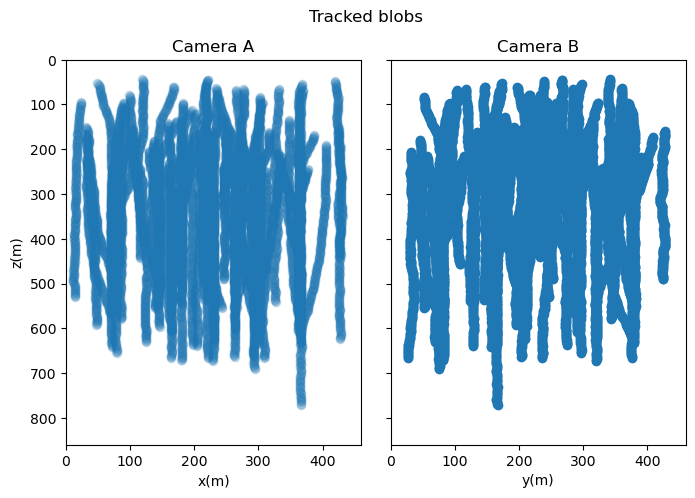

In [36]:
# Plot data
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
plt.subplots_adjust(wspace=0.1)
fig.suptitle('Tracked blobs')
axs[0].scatter(xA[:, 0], zA[:,0], alpha=0.2)
axs[0].set_ylim([860, 0])
axs[0].set_xlim([0, 460])
axs[0].set_xlabel('x(m)')
axs[0].set_ylabel('z(m)')
axs[0].set_title('Camera A')

axs[1].scatter(yB[:, 0], zB[:,0])
axs[1].set_ylim([860, 0])
axs[1].set_xlim([0, 460])
axs[1].set_xlabel('y(m)')
axs[1].set_title('Camera B')
axs[1].set_yticklabels([])
plt.show()

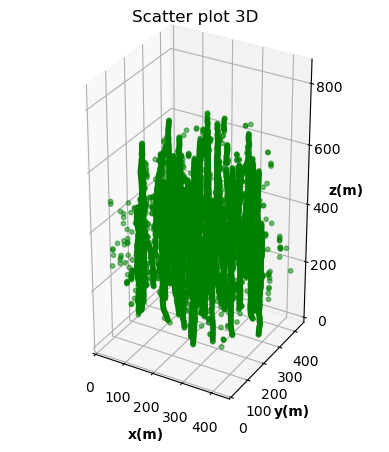

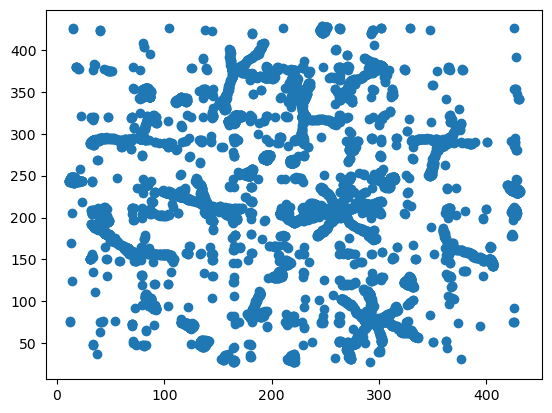

In [37]:
# matching particle tracks (without taking into account previous particle position)
x3D = np.zeros(0)
y3D = np.zeros(0)
z3DA = np.zeros(0)
z3DB = np.zeros(0)

for i in range(len(xA[:,0])):
    #take points on ith frame
    maskA = (xA[:,1] == i)
    maskB = (yB[:,1] == i)
    
    x = xA[:,0][maskA]
    y = yB[:,0][maskB]
    za = zA[:,0][maskA]
    zb = zB[:,0][maskB]
    
    for j in range(1, len(x)):
        #take z and x coordiate to match
        z0A = za[j]
        x0 = x[j]
        
        #find smallest distance between in list of zb and z0
        zlist = abs(zb - z0A)
        index = np.argmin(zlist) #finds index of smallest value, aka smallest distance
        
        y0 = y[index]
        z0B = zb[index]
        
        #save to arrays
        x3D = np.append(x3D, x0)
        y3D = np.append(y3D, y0)
        z3DA = np.append(z3DA, z0A)
        z3DB = np.append(z3DB, z0B)

# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
ax1.scatter(x3D, y3D, z3DA, color = "green", alpha = 0.5, s = 10)
#ax.scatter3D(x3D, y3D, z3DB, color = "blue", alpha = 0.5, s = 10)
plt.title("Scatter plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450)
ax1.set_ylim(0, 450)
ax1.set_zlim(0, 860)
# show plot
plt.show()

plt.figure()
plt.scatter(x3D, y3D)

In [38]:
# search radius
R = 7
Rz = 2

# starting points, take points on the last frame, where particles are nicely separated:
maskA0 = (xA[:,1] == nN)
x00 = xA[:,0][maskA0]
z00A = zA[:,0][maskA0]

maskB0 = (yB[:,1] == nN)
y00 = yB[:,0][maskB0]
z00B = zB[:,0][maskB0]

#arrays to save the path, coordinate, frame nr, particle nr
#camera A
path_xA = np.zeros((1,3))
path_zA = np.zeros((1,3))

#camera B
path_yB = np.zeros((1,3))
path_zB = np.zeros((1,3))

for i in tqdm(range(len(x00))):
    #save first coordinate
    path_xA = np.vstack((path_xA, np.array([x00[i], nN, i])))
    path_zA = np.vstack((path_zA, np.array([z00A[i], nN, i])))

    #find smallest distance between in list of zb and za
    zlist = abs(z00B-z00A[i])
    index = np.argmin(zlist) #finds index of smallest value, aka smallest distance

    path_yB = np.vstack((path_yB, np.array([y00[index], nN, i])))
    path_zB = np.vstack((path_zB, np.array([z00B[index], nN, i])))

    for j in reversed(range(1, nN)):
        # find points on next frame
        maskA0 = (xA[:,1] == j)
        x001 = xA[:,0][maskA0]
        z00A1 = zA[:,0][maskA0]

        maskB0 = (yB[:,1] == j)
        y001 = yB[:,0][maskB0]
        z00B1 = zB[:,0][maskB0]

        #first find closest point to previous position on camera A:
        distance = np.sqrt(abs(z00A1-path_zA[-1,0])**2 + abs(x001-path_xA[-1,0])**2)
        index = np.argmin(distance)

        path_xA = np.vstack((path_xA, np.array([x001[index], j, i])))
        path_zA = np.vstack((path_zA, np.array([z00A1[index], j, i])))

        #find closest za and zb
        #find smallest distance between in list of zb and za
        #zlist = abs(z00B-z00A[index])
        #index2 = np.argmin(zlist) #finds index of smallest value, aka smallest distance

        #find closest point to previous position on camera B:
        distance = np.sqrt(abs(z00B1-path_zB[-1,0])**2 + abs(y001-path_yB[-1,0])**2)
        index1 = np.argmin(distance)

        path_yB = np.vstack((path_yB, np.array([y001[index1], j, i])))
        if abs(z00B1[index1] - z00A1[index]) > Rz:
            path_zB = np.vstack((path_zB, np.array([z00A1[index], j, i])))
        else:
            path_zB = np.vstack((path_zB, np.array([z00B1[index1], j, i])))


path_xA = path_xA[1:,:]
path_zA = path_zA[1:,:]
path_yB = path_yB[1:,:]
path_zB = path_zB[1:,:] 

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 39.78it/s]


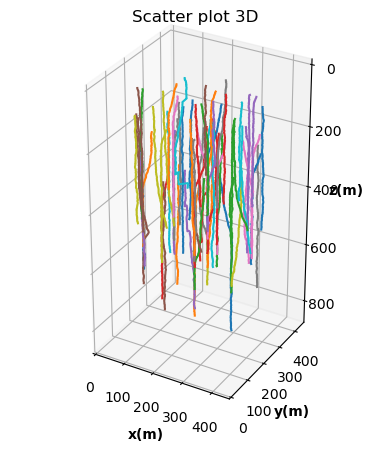

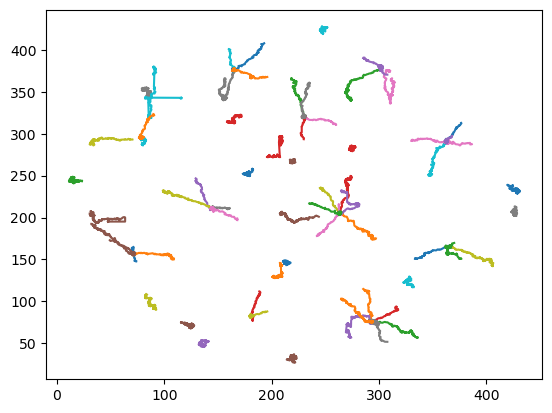

In [39]:
# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
for i in range(0, len(x00)):
    mask = (path_xA[:,2]==i)
    ax1.plot(path_xA[:,0][mask], path_yB[:,0][mask], path_zA[:,0][mask])
plt.title("Scatter plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450)
ax1.set_ylim(0, 450)
ax1.set_zlim(860, 0)
# show plot
plt.show()

plt.figure()
for i in range(0, len(x00)):
    mask = (path_xA[:,2]==i)
    plt.plot(path_xA[:,0][mask], path_yB[:,0][mask])
    
plt.show()

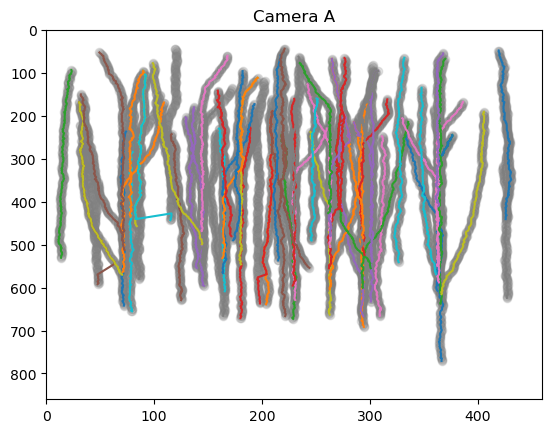

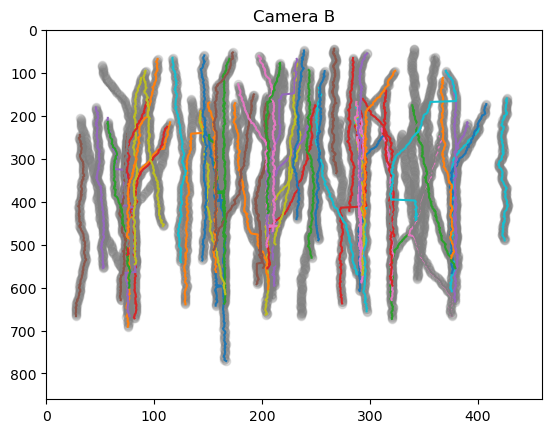

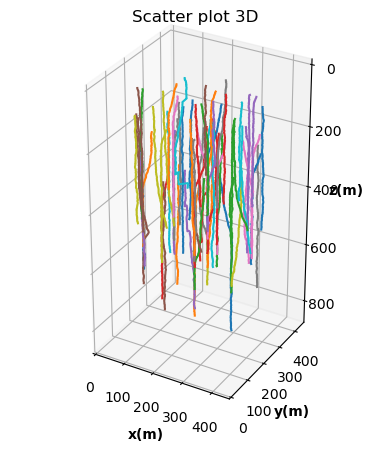

In [40]:
# Plot data
plt.figure()
plt.scatter(xA[:, 0], zA[:,0], alpha=0.2, c='gray')
for i in range(0, len(x00)):
    mask = (path_xA[:,2]==i)
    plt.plot(path_xA[:,0][mask], path_zA[:,0][mask])
plt.ylim(860, 0)
plt.xlim(0, 460)
plt.title('Camera A')
plt.show()

plt.figure()
plt.scatter(yB[:, 0], zB[:,0], alpha=0.2, c='gray')
for i in range(0, len(x00)):
    mask = (path_yB[:,2]==i)
    plt.plot(path_yB[:,0][mask], path_zA[:,0][mask])
plt.ylim(860, 0)
plt.xlim(0, 460)
plt.title('Camera B')
plt.show()

# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
for i in range(0, len(x00)):
    mask = (path_xA[:,2]==i)
    ax1.plot(path_xA[:,0][mask], path_yB[:,0][mask], path_zA[:,0][mask])
plt.title("Scatter plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450)
ax1.set_ylim(0, 450)
ax1.set_zlim(860, 0)
# show plot
plt.show()

In [42]:
# search radius
#trying to improve on previous one
R = 6
Rz = 2

# starting points, take points on the last frame, where particles are nicely separated:
maskA0 = (xA[:,1] == nN)
x00 = xA[:,0][maskA0]
z00A = zA[:,0][maskA0]

maskB0 = (yB[:,1] == nN)
y00 = yB[:,0][maskB0]
z00B = zB[:,0][maskB0]

#arrays to save the path, coordinate, frame nr, particle nr
#camera A
path_xA = np.zeros((1,3))
path_zA = np.zeros((1,3))

#camera B
path_yB = np.zeros((1,3))
path_zB = np.zeros((1,3))

for i in tqdm(range(len(x00))):
    #save first coordinate
    path_xA = np.vstack((path_xA, np.array([x00[i], nN, i])))
    path_zA = np.vstack((path_zA, np.array([z00A[i], nN, i])))

    #find smallest distance between in list of zb and za
    zlist = abs(z00B-z00A[i])
    index = np.argmin(zlist) #finds index of smallest value, aka smallest distance

    path_yB = np.vstack((path_yB, np.array([y00[index], nN, i])))
    path_zB = np.vstack((path_zB, np.array([z00B[index], nN, i])))

    for j in reversed(range(1, nN)):
        # find points on next frame
        maskA0 = (xA[:,1] == j)
        x001 = xA[:,0][maskA0]
        z00A1 = zA[:,0][maskA0]

        maskB0 = (yB[:,1] == j)
        y001 = yB[:,0][maskB0]
        z00B1 = zB[:,0][maskB0]
        
        #first find closest point to previous position on camera A:
        distance = np.sqrt(abs(z00A1-path_zA[-1,0])**2 + abs(x001-path_xA[-1,0])**2)
        index = np.argmin(distance)
        #only save if distance smaller than R
        if distance[index] < R:

            path_xA = np.vstack((path_xA, np.array([x001[index], j, i])))
            path_zA = np.vstack((path_zA, np.array([z00A1[index], j, i])))

            #find closest za and zb
            #find smallest distance between in list of zb and za
            #zlist = abs(z00B-z00A[index])
            #index2 = np.argmin(zlist) #finds index of smallest value, aka smallest distance

            #find closest point to previous position on camera B:
            distance = np.sqrt(abs(z00B1-path_zB[-1,0])**2 + abs(y001-path_yB[-1,0])**2)
            index1 = np.argmin(distance)

            path_yB = np.vstack((path_yB, np.array([y001[index1], j, i])))
            if abs(z00B1[index1] - z00A1[index]) > Rz:
                path_zB = np.vstack((path_zB, np.array([z00A1[index], j, i])))
            else:
                path_zB = np.vstack((path_zB, np.array([z00B1[index1], j, i])))


path_xA = path_xA[1:,:]
path_zA = path_zA[1:,:]
path_yB = path_yB[1:,:]
path_zB = path_zB[1:,:] 

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 36.74it/s]


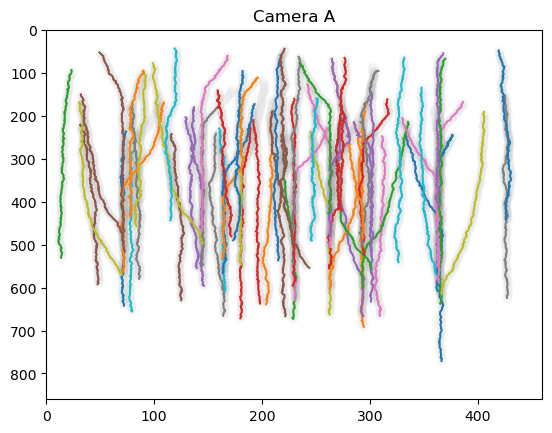

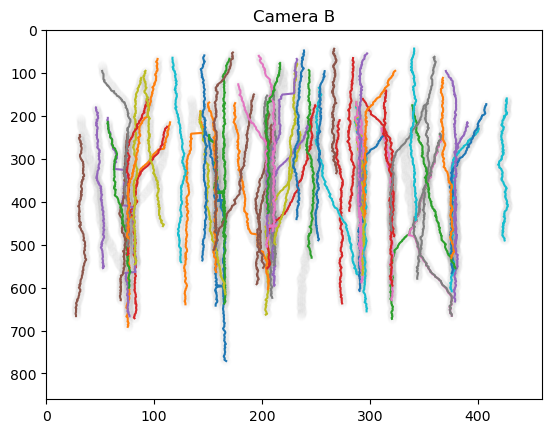

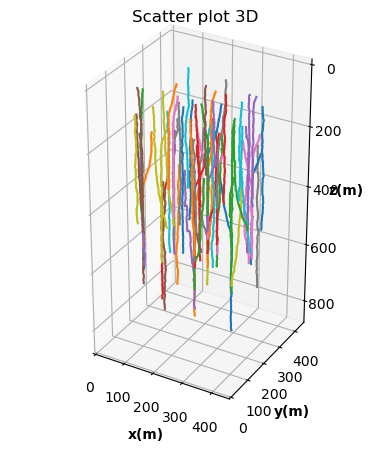

In [28]:
# Plot data
plt.figure()
plt.scatter(xA[:, 0], zA[:,0], alpha=0.01, c='gray')
for i in range(0, len(x00)):
    mask = (path_xA[:,2]==i)
    plt.plot(path_xA[:,0][mask], path_zA[:,0][mask])
plt.ylim(860, 0)
plt.xlim(0, 460)
plt.title('Camera A')
plt.show()

plt.figure()
plt.scatter(yB[:, 0], zB[:,0], alpha=0.01, c='gray')
for i in range(0, len(x00)):
    mask = (path_yB[:,2]==i)
    plt.plot(path_yB[:,0][mask], path_zA[:,0][mask])
plt.ylim(860, 0)
plt.xlim(0, 460)
plt.title('Camera B')
plt.show()

# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
for i in range(0, len(x00)):
    mask = (path_xA[:,2]==i)
    ax1.plot(path_xA[:,0][mask], path_yB[:,0][mask], path_zA[:,0][mask])
plt.title("Scatter plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450)
ax1.set_ylim(0, 450)
ax1.set_zlim(860, 0)
# show plot
plt.show()

### a5) Velocity

In [48]:
fps = 25 #Hz
dt = 1/fps
v = np.zeros(0)
for i in tqdm(range(0, len(x00))): #for each particle
    mask = (path_xA[:,2]==i)
    x = path_xA[mask][:,0:2]
    y = path_yB[:,0:2][mask]
    z = path_zA[:,0:2][mask]
    
    for j in range(len(x)-1): #for each frame
        distance = np.sqrt(abs(x[j+1,0]-x[j, 0])**2 + abs(y[j+1,0]-y[j, 0])**2 + abs(z[j+1,0]-z[j, 0])**2)
        time = dt*(x[j+1,1]-x[j,1])
        
        v = np.append(v, distance/time)

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 316.57it/s]


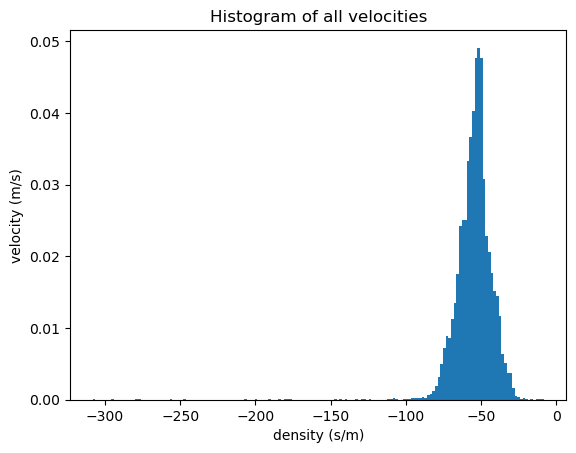

In [49]:
plt.figure()
plt.hist(v, bins='scott', density=True)
plt.title('Histogram of all velocities')
plt.ylabel('velocity (m/s)')
plt.xlabel('density (s/m)')
plt.show()

In [68]:
angle_1to99 = np.zeros(0)
angle_100to200 = np.zeros(0)

import math

for i in tqdm(range(0, len(x00))): #for each particle
    for j in range(1, 100): #for each frame
        mask = (path_xA[:,2] == i) & (path_xA[:,1] == j) #for particle i, on frame j
        x = path_xA[:,0][mask]
        y = path_yB[:,0][mask]
        z = path_zA[:,0][mask]
        
        if len(x) != 0:
        
            mask2 = (path_xA[:,2] != i) & (path_xA[:,1] == j) #for all other particles, on frame j
            x_other = path_xA[:,0][mask2]
            y_other = path_yB[:,0][mask2]
            z_other = path_zA[:,0][mask2]

            distances = np.sqrt(abs(x-x_other)**2 + abs(y-y_other)**2 + abs(z-z_other)**2)
            mask3 = (distances <= 100) #should be 0.4 meter, but didn't include calibration yet
            x_other = x_other[mask3]
            y_other = y_other[mask3]
            z_other = z_other[mask3]
            
            #print(x_other)

            #calculate angle somehow
            for k in range(len(x_other)):
                theta = math.acos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2 + abs(z-z_other[k])**2))
                angle_1to99 = np.append(angle_1to99, theta)
    
                   
for i in tqdm(range(0, len(x00))): #for each particle
    for j in range(100, 201): #for each frame
        mask = (path_xA[:,2] == i) & (path_xA[:,1] == j) #for particle i, on frame j
        x = path_xA[:,0][mask]
        y = path_yB[:,0][mask]
        z = path_zA[:,0][mask]
        
        if len(x) != 0:
        
            mask2 = (path_xA[:,2] != i) & (path_xA[:,1] == j) #for all other particles, on frame j
            x_other = path_xA[:,0][mask2]
            y_other = path_yB[:,0][mask2]
            z_other = path_zA[:,0][mask2]

            distances = np.sqrt(abs(x-x_other)**2 + abs(y-y_other)**2 + abs(z-z_other)**2)
            mask3 = (distances <= 100) #should be 0.4 meter, but didn't include calibration yet
            x_other = x_other[mask3]
            y_other = y_other[mask3]
            z_other = z_other[mask3]
            
            #print(x_other)

            #calculate angle somehow
            for k in range(len(x_other)):
                theta = math.acos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2 + abs(z-z_other[k])**2))
                angle_100to200 = np.append(angle_100to200, theta)
    
                   
        

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 52.73it/s]


57684


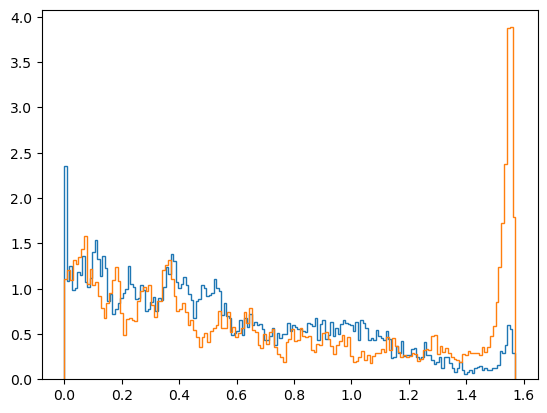

In [70]:
print(len(angle))

plt.figure()
plt.hist(angle_1to99, bins=int(np.sqrt(len(angle_1to99))), density='True', histtype='step')
plt.hist(angle_100to200, bins=int(np.sqrt(len(angle_100to200))), density='True', histtype='step')
plt.show()